<a href="https://colab.research.google.com/github/dbarriogil/Final_assignment_unsupervised/blob/main/Practica_Final_MLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Final: Análisis predictivo del precio de jugadores de fútbol.**


---


CUNEF. Junio 2022.
Asignatura: Modelos Supervisados
Alumnos: **Javier Tauroni** y **Damián Barrio**.

## Librerías

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
#cargamos librerías


# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression



# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier



## Datos

In [188]:
#carga de datos
#players = pd.read_excel("players_22_1.xlsx")
players = pd.read_excel("/content/drive/MyDrive/players_22_1.xlsx")\
.set_index(["long_name"])

In [189]:
players.head()

,sofifa_id,player_url,short_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
long_name,,,,,,,,,,,,,,,,,,,,,
Lionel Andrés Messi Cuccittini,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,...,96,20,35,24,6,11,15,14,8,NaN
Robert Lewandowski,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,...,88,35,42,19,15,6,12,8,10,NaN
Cristiano Ronaldo dos Santos Aveiro,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,...,95,24,32,24,7,11,15,14,11,NaN
Neymar da Silva Santos Júnior,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,...,93,35,32,29,9,9,15,15,11,NaN
Kevin De Bruyne,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,1991-06-28,...,89,68,65,53,15,13,5,10,13,NaN


# Funciones

In [190]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def missing_values_table(df):

    mis_val = df.isnull().sum()

    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(

    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[

        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(

    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      

        "There are " + str(mis_val_table_ren_columns.shape[0]) +

            " columns that have missing values.")

    return mis_val_table_ren_columns


def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

def plot_roc_gini(y_true=None,y_pred=None, size_figure=[9,9], tittle = 'Curva Roc'):

    if ((y_true is None) or (y_pred is None)):
        print(u'\nFaltan parámetros por pasar a la función')
        return 1

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=size_figure)
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(tittle)
    plt.legend(loc="lower right")
    plt.show()

    gini = (2.0 * roc_auc) - 1.0

    print('\n*************************************************************')
    print(u'\nEl coeficiente de GINI es: %0.2f' % gini)
    print(u'\nEl área por debajo de la curva ROC es: %0.2f' %roc_auc)
    print('\n*************************************************************')

    return 0


# Análisis Exploratorio

## Filtrado de las columnas

In [191]:
#eliminamos las columnas que no aportan infomación
players = players.drop(["league_level", "dob","club_joined","nation_position","player_url","short_name","sofifa_id","club_team_id","club_jersey_number","club_loaned_from","nationality_id","nation_team_id","nation_jersey_number","body_type","real_face","player_tags","player_traits"], axis = 1)

Eliminamos estas variables porque algunas contienen información redundante como puede ser  **nation_position** al contar ya con la variable **club_position** que contiene mayor información debido a que no todos los jugadores han debutado con la selección de su país.

**Sofifa_id** y **club_team_id**, por ejemplo, indican el identificador de los jugadores y clubes, respectivamente.

Otras variables como **dob** y **club_joined** que son de tipo fecha, no nos aportan información al contar con otras variables como la edad del jugador.



In [192]:
# Dimensiones del dataset
# ==============================================================================
players.shape

(19239, 60)

Nuestro Dataframe cuenta con 19.239 filas y 60 columnas.

## Tipos de Variables

In [193]:
# Tipo de cada columna
# ==============================================================================
players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19239 entries, Lionel Andrés Messi Cuccittini to Emanuel Lalchhanchhuaha
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_positions             19239 non-null  object 
 1   overall                      19239 non-null  int64  
 2   potential                    19239 non-null  int64  
 3   value_eur                    19165 non-null  float64
 4   wage_eur                     19178 non-null  float64
 5   age                          19239 non-null  int64  
 6   height_cm                    19239 non-null  int64  
 7   weight_kg                    19239 non-null  int64  
 8   club_name                    19178 non-null  object 
 9   league_name                  19178 non-null  object 
 10  club_position                19178 non-null  object 
 11  club_contract_valid_until    19178 non-null  float64
 12  nationality_name             192

In [194]:
# Cambio de variables a tipo Object
# ==============================================================================
players["weak_foot"] = players["weak_foot"].astype('object')
players["skill_moves"] = players["skill_moves"].astype('object')
players["international_reputation"] = players["international_reputation"].astype('object')


Modificamos las anteriores variables que, aunque en un principio nos aparezcan con formato numérico, suponen una sola categoría para cada jugador y,las mismas no deberían ser tratadas como si de un número tratara.

## Valores Missing

In [195]:
# Número de datos ausentes por variable
# ==============================================================================
missing_values_table(players)

Your selected dataframe has 60 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
goalkeeping_speed,17107,88.9
pace,2132,11.1
shooting,2132,11.1
passing,2132,11.1
dribbling,2132,11.1
defending,2132,11.1
physic,2132,11.1
release_clause_eur,1176,6.1
value_eur,74,0.4
wage_eur,61,0.3


La variable que cuenta con un mayor número de **datos missing** es la variable que indica la velocidad del portero que, puede es lógico debido a que la mayor parte de los jugadores de fútbol no ocupan esta posición al ser la posición con menos jugadores en cada equipo.

In [196]:
players = players.dropna(subset=["value_eur","wage_eur"])

Hemos decidido que los jugadores que no disponen de datos sobre su **valor** y **sueldo** vamos a eliminarlos ya que coincide que no se encontraban en activo.

## Tratamiento de outliers

In [197]:
Q1 = players.quantile(0.25)
Q3 = players.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

overall                              9.0
potential                            8.0
value_eur                      1525000.0
wage_eur                          7000.0
age                                  8.0
height_cm                           10.0
weight_kg                           10.0
club_contract_valid_until            2.0
release_clause_eur             2894000.0
pace                                14.0
shooting                            21.0
passing                             13.0
dribbling                           12.0
defending                           27.0
physic                              13.0
attacking_crossing                  25.0
attacking_finishing                 32.0
attacking_heading_accuracy          20.0
attacking_short_passing             14.0
attacking_volleys                   26.0
skill_dribbling                     18.0
skill_curve                         26.0
skill_fk_accuracy                   24.0
skill_long_passing                  20.0
skill_ball_contr

In [198]:
players = players[~((players < (Q1 - 1.5 * IQR)) |(players > (Q3 + 1.5 * IQR))).any(axis=1)]

players.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.


(13137, 60)

Disponemos a eliminar los **Outliers** de nuestro Dataframe para afinar nuestro modelo utilizando la técnica del Rango Intercuartílico. Muchos jugadores se encontraban por debajo de los límites establecidos considerándose valores atípicos, y por otro lado, jugadores como Mbappé, Neymar o Messi también se eliminan al tener un excesivo valor de mercado que desvirtuaría nuestro modelo.

## Análisis de la Variable Objetivo

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

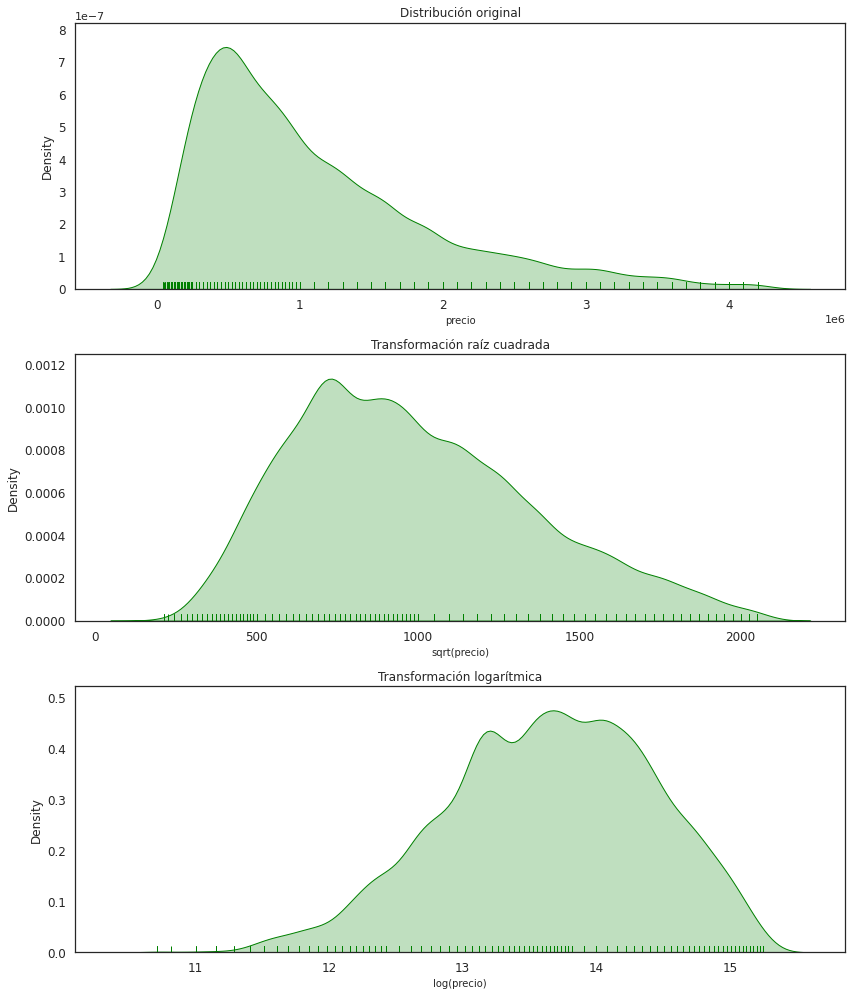

In [199]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 14))
sns.distplot(
    players.value_eur,
    hist    = False,
    rug     = True,
    color   = "green",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 12)

sns.distplot(
    np.sqrt(players.value_eur),
    hist    = False,
    rug     = True,
    color   = "green",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 12)

sns.distplot(
    np.log(players.value_eur),
    hist    = False,
    rug     = True,
    color   = "green",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 12)

fig.tight_layout()

En estos gráficos sobre cómo se distribuye nuestra **variable objetivo**, podemos observar que la mayor parte de los jugadores tienen un valor de mercado de entre **0,4** y **1 millón de euros**

## Análisis de las Variables Numéricas

In [200]:
# Variables numéricas
# ==============================================================================
players.select_dtypes(include=['float64', 'int']).describe()

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_contract_valid_until,release_clause_eur,pace,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,13137.000000,13137.000000,1.313700e+04,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,1.238900e+04,13137.000000,...,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,0.0
mean,64.288650,69.961026,1.107810e+06,3782.960341,24.782370,180.139986,73.757327,2022.674507,1.966024e+06,68.425516,...,58.032427,49.126437,50.863668,48.664383,10.321230,10.384715,10.315673,10.344371,10.296262,NaN
std,5.075867,4.995720,8.191417e+05,3796.047653,4.555942,6.284113,6.344351,1.171896,1.554118e+06,9.588239,...,8.694610,16.566141,17.722083,17.553813,3.002161,2.956851,3.000481,2.962413,2.996991,NaN
min,48.000000,55.000000,4.500000e+04,500.000000,16.000000,161.000000,55.000000,2021.000000,6.100000e+04,41.000000,...,32.000000,10.000000,10.000000,10.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN
25%,61.000000,67.000000,5.000000e+05,1000.000000,21.000000,175.000000,70.000000,2022.000000,8.310000e+05,63.000000,...,52.000000,35.000000,36.000000,33.000000,8.000000,8.000000,8.000000,8.000000,8.000000,NaN
50%,65.000000,70.000000,8.750000e+05,2000.000000,24.000000,180.000000,74.000000,2022.000000,1.500000e+06,69.000000,...,58.000000,55.000000,58.000000,55.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN
75%,68.000000,73.000000,1.500000e+06,5000.000000,28.000000,185.000000,78.000000,2023.000000,2.600000e+06,75.000000,...,64.000000,62.000000,65.000000,63.000000,13.000000,13.000000,13.000000,13.000000,13.000000,NaN
max,77.000000,87.000000,4.200000e+06,18000.000000,39.000000,201.000000,95.000000,2027.000000,8.000000e+06,94.000000,...,85.000000,84.000000,80.000000,79.000000,23.000000,19.000000,22.000000,23.000000,21.000000,NaN


Est tabla nos muestra un pequeño análisis general de las variables numéricas de nuestro dataframe. Por ejeplo, podemos ver que la mediana de la **claúsula de rescisión es 1,5 millones de euros** y, la **edad media de los jugadores es de 25 años**, aproximadamente.

In [201]:
players[players.index.duplicated()]

,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_name,league_name,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
long_name,,,,,,,,,,,,,,,,,,,,,
Rhys Williams,CB,65,81,1800000.0,13000.0,20,195,76,Swansea City,English League Championship,...,59,63,68,59,5,14,5,12,14,NaN
Boubacar Fofana,LM,63,71,1100000.0,3000.0,22,183,74,Servette FC,Swiss Super League,...,58,28,26,37,14,7,10,15,6,NaN
刘洋,CB,62,62,325000.0,2000.0,30,188,79,Shijiazhuang Ever Bright F.C.,Chinese Super League,...,48,60,57,56,11,9,15,13,8,NaN
Gideon Mensah,"CB, RB",60,68,500000.0,500.0,20,183,75,Varbergs BoIS FC,Swedish Allsvenskan,...,44,56,60,58,13,12,8,7,13,NaN
Sambou Sissoko,"RB, LB",59,67,475000.0,3000.0,22,186,73,Stade de Reims,French Ligue 1,...,49,50,58,57,8,7,6,14,11,NaN
Mamadou Fofana,"CM, CDM",58,67,450000.0,850.0,20,177,70,Amiens SC,French Ligue 2,...,51,50,52,50,5,5,9,6,11,NaN
Souleymane Cissé,CB,58,64,300000.0,850.0,22,190,80,US Quevilly Rouen Métropole,French Ligue 2,...,43,55,62,61,7,11,7,7,12,NaN
Ibrahima Baldé,ST,57,68,350000.0,2000.0,18,185,75,Racing Club de Lens,French Ligue 1,...,46,16,18,16,10,6,10,10,9,NaN
Pablo Martinez,"CM, CB",56,64,300000.0,2000.0,20,186,75,Bristol Rovers,English League Two,...,52,51,57,58,6,8,14,6,5,NaN


In [202]:
players = players[~players.index.duplicated()]

Quitamos los jugadores que aparecen duplicados puesto que es un error del data frame.



### Distribución Variables Numéricas

Como es de imaginar, prácticamente todas las variables numéricas tienen una distribución centrada en la media.
Sin embargo, algunos datos como el **wage_eur** se encuentra muy sesgado hacia la zona baja, es decir, la mayoría de los jugadores cuentan con unos salarios bajos.

Igualmente ocurre con **release_clause_eur** cuya explicación reside en que al retirar los outliers (la gran mayoría jugadores de las grandes ligas) nos quedan jugadores con claúsulas muy bajas o sin ellas.

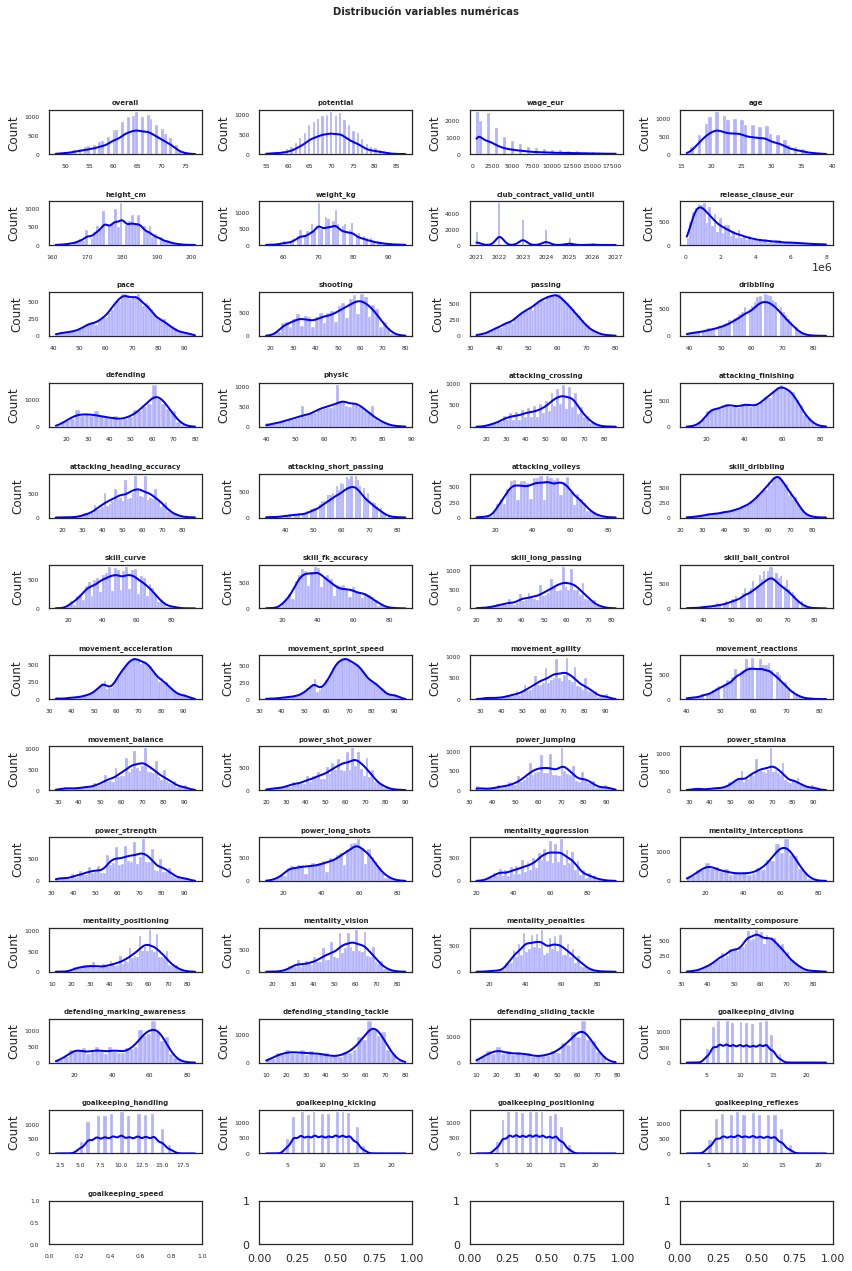

In [203]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(12, 18))
axes = axes.flat
columnas_numeric = players.select_dtypes(include=['float64', 'int64']).columns
columnas_numeric = columnas_numeric.drop('value_eur')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = players,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = "blue",
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");



Podemos observar como se distribuyen las variables categóricas en función del precio, pudiendo comprobar que, para casi la totalidad de los datos a medida que aumentan, la variable objetivo también lo hace.

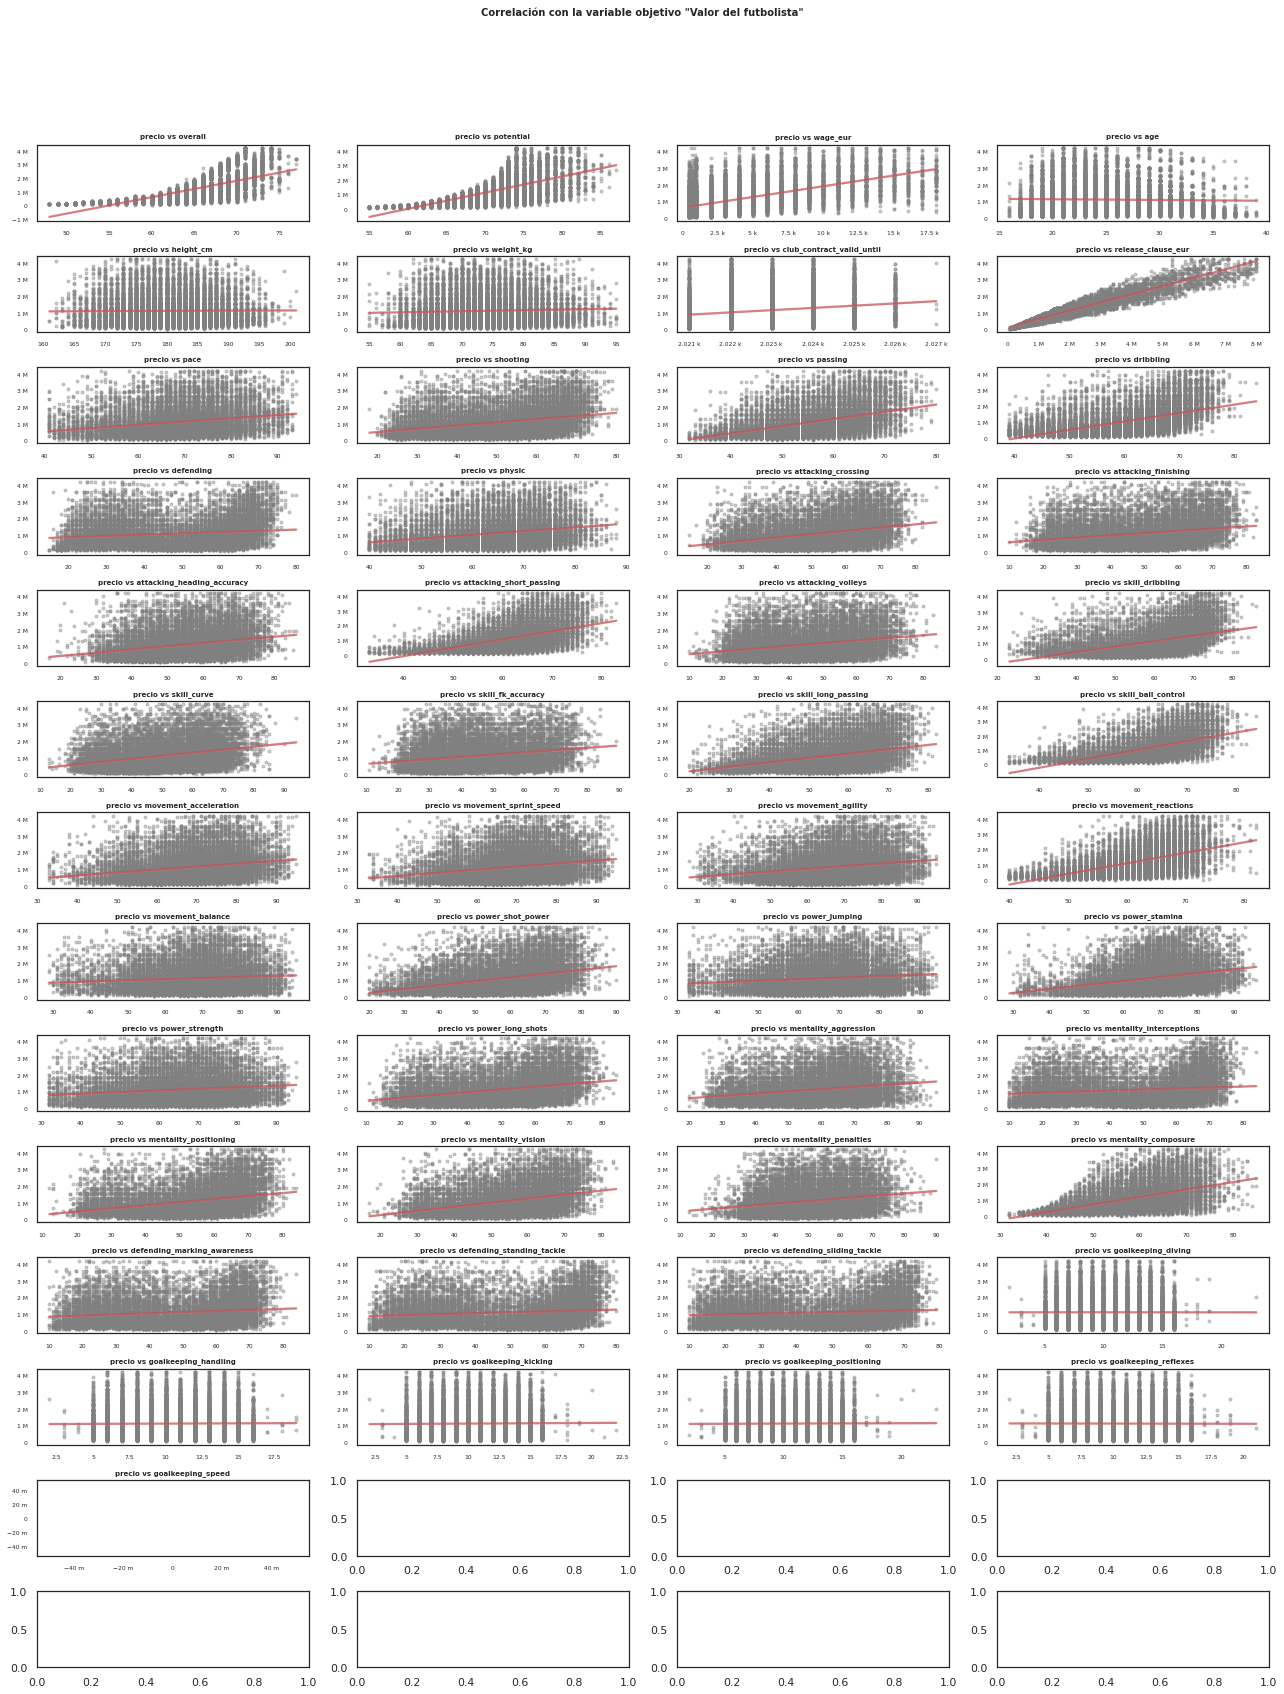

In [204]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=14, ncols=4, figsize=(18, 24))
axes = axes.flat
columnas_numeric = players.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('value_eur')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = players[colum],
        y           = players['value_eur'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
#for i in [8]:
    #fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con la variable objetivo "Valor del futbolista"', fontsize = 10, fontweight = "bold");

## Matriz de Correlaciones 

In [205]:
# Correlación entre columnas numéricas
# ==============================================================================

corr_matrix = players.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
2071,defending_standing_tackle,defending,0.976594,0.976594
679,defending,defending_standing_tackle,0.976594,0.976594
2101,defending_standing_tackle,defending_sliding_tackle,0.968720,0.968720
2149,defending_sliding_tackle,defending_standing_tackle,0.968720,0.968720
1283,movement_sprint_speed,pace,0.966369,0.966369
467,pace,movement_sprint_speed,0.966369,0.966369
1777,mentality_interceptions,defending,0.965114,0.965114
673,defending,mentality_interceptions,0.965114,0.965114
2022,defending_marking_awareness,defending,0.964734,0.964734
678,defending,defending_marking_awareness,0.964734,0.964734


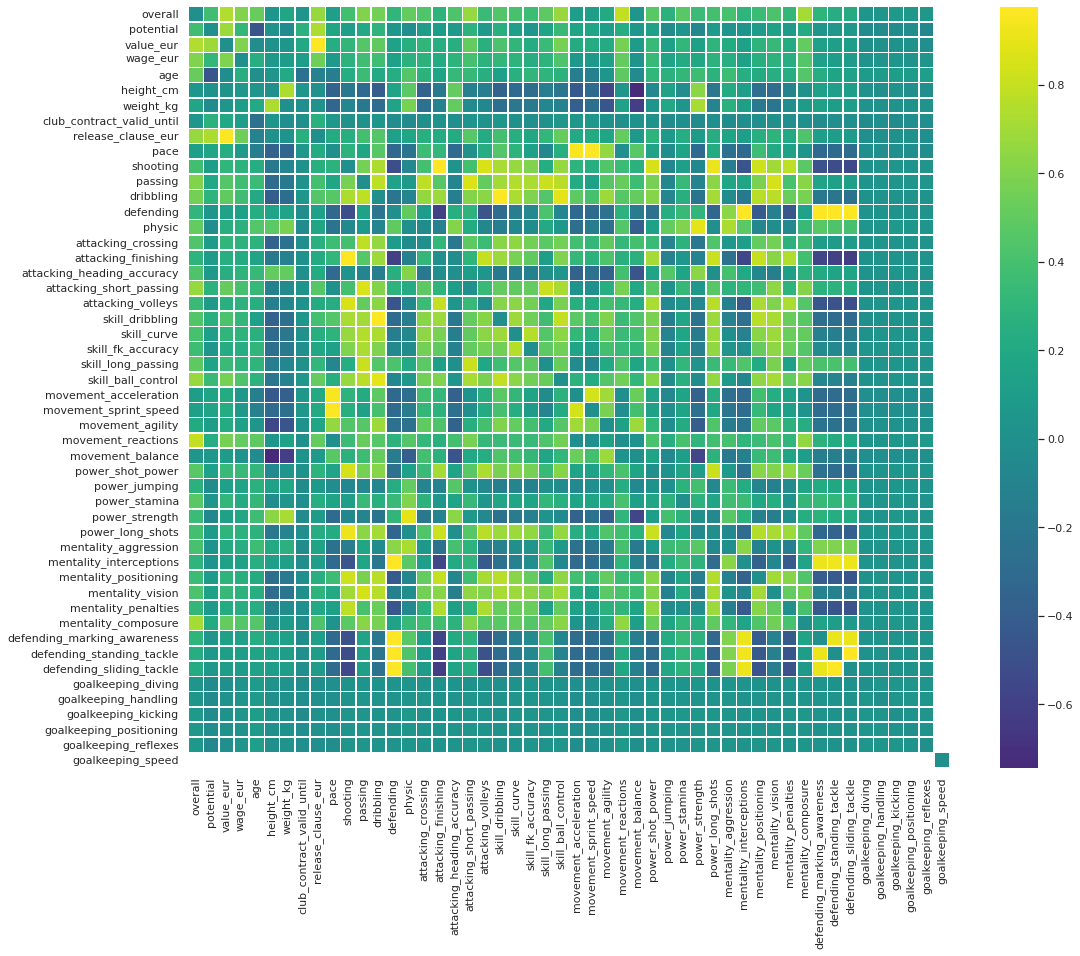

0

In [206]:
var_continuous = players.select_dtypes(include=['float64', 'int'])
get_corr_matrix(var_continuous, 
                metodo='pearson', size_figure=[18,14])

Aquí, hemos graficado la **Matriz de Correlaciones** de las variables numéricas en su conjunto. A continuación, hemos decidido eliminar la variable **release_clause_eur** al ser la variable más correlacionada (positivamente) con la variable objetivo (**precio del jugador**), ya que contiene así información redundante.

In [207]:
players = players.drop(["release_clause_eur"], axis = 1)

## Análisis de las Variables Categóricas

In [208]:
# Variables cualitativas (tipo object)
# ==============================================================================
players.select_dtypes(include=['object']).describe()

,player_positions,club_name,league_name,club_position,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate
count,13126,13126,13126,13126,13126,13126,13126,13126,13126,13126
unique,620,701,55,28,158,2,5,4,3,9
top,CB,Luton Town,Argentina Primera División,SUB,England,Right,3,2,1,Medium/Medium
freq,1553,28,567,5801,1226,9804,8556,7846,12929,6443


In [209]:
# Separamos los valores de la variable que indican las posibles posiciones del jugador en el terreno de juego
players[["position","eliminar1","eliminar2"]] = players["player_positions"].str.split(",",expand = True) 

In [210]:
players = players.drop(["player_positions","eliminar1","eliminar2"], axis = 1)

In [211]:
players["position"].unique()

array(['RW', 'CDM', 'CB', 'LW', 'LB', 'RM', 'CAM', 'ST', 'RB', 'CF', 'CM',
       'LM', 'LWB', 'RWB'], dtype=object)

Vemos como nos hemos quedado con la primera y principal posición del jugador

### Distribución Variables Categóricas

A continuación, podemos ver como se distribuyen los jugadores en función de las características que nos aportan las siguientes variables categóricas:


*   **Preferred_foot**: esta variable refleja que la mayor parte de los jugadores son diestros y que, por tanto, su pierna dominante es la derecha. Por el contrario, apenas más de 3.000 jugadores son zurdos.
*  **Work_rate**: la mayor parte de jugadoreseconcentra en el nivel de trabajo o esfuerzo **medio** ya qe esta variable se compensa tanto con los delanteros que suelen tener niveles de esfuerzo por debajo de los defensas o los mediocentros.
*   **Position**: La mayor parte de los jugadores ocupan la posición de **CB** (más de 2.000), es decir, la posición de *centre-back* o en español **Defensa Central** seguido de **ST**, *stricker* o **Delantero Centro** en español.
*   **League_name**: como podemos observar, contamos con un mayor número de jugadores en nuestro Dataframe de la *Primera Divisiçon Argentina*, *La Premier League o Primera División Inglesa*, *MLS o Liga de USA* o la *Liga Española*.
*   **Skill_moves**: la mayor parte de los jugadores (casi 8.000) de nuestro Dataframe presentan habilidades técnicas con una puntuación de **2 sobre 5**. Podemos decir que en nuestro Dataframe hay pocos jugadores con buenas habilidades técnicas al haber eliminado a los jugadores más caros como Messi, Neymar, Ronaldo y que son los que mejor dotación técnica presentan.
*   **Weak_foot**: esta variable nos muestra el dominio de los jugadores de su pierna menos dominante, teniendo la mayoría de ellos (más de 8.000) un manejo de **3 sobre 5**. Dato que muestra el por qué estos han llegado a ser futbolistas profesionales al ser un aspecto muy relevante en el fútbol de élite.










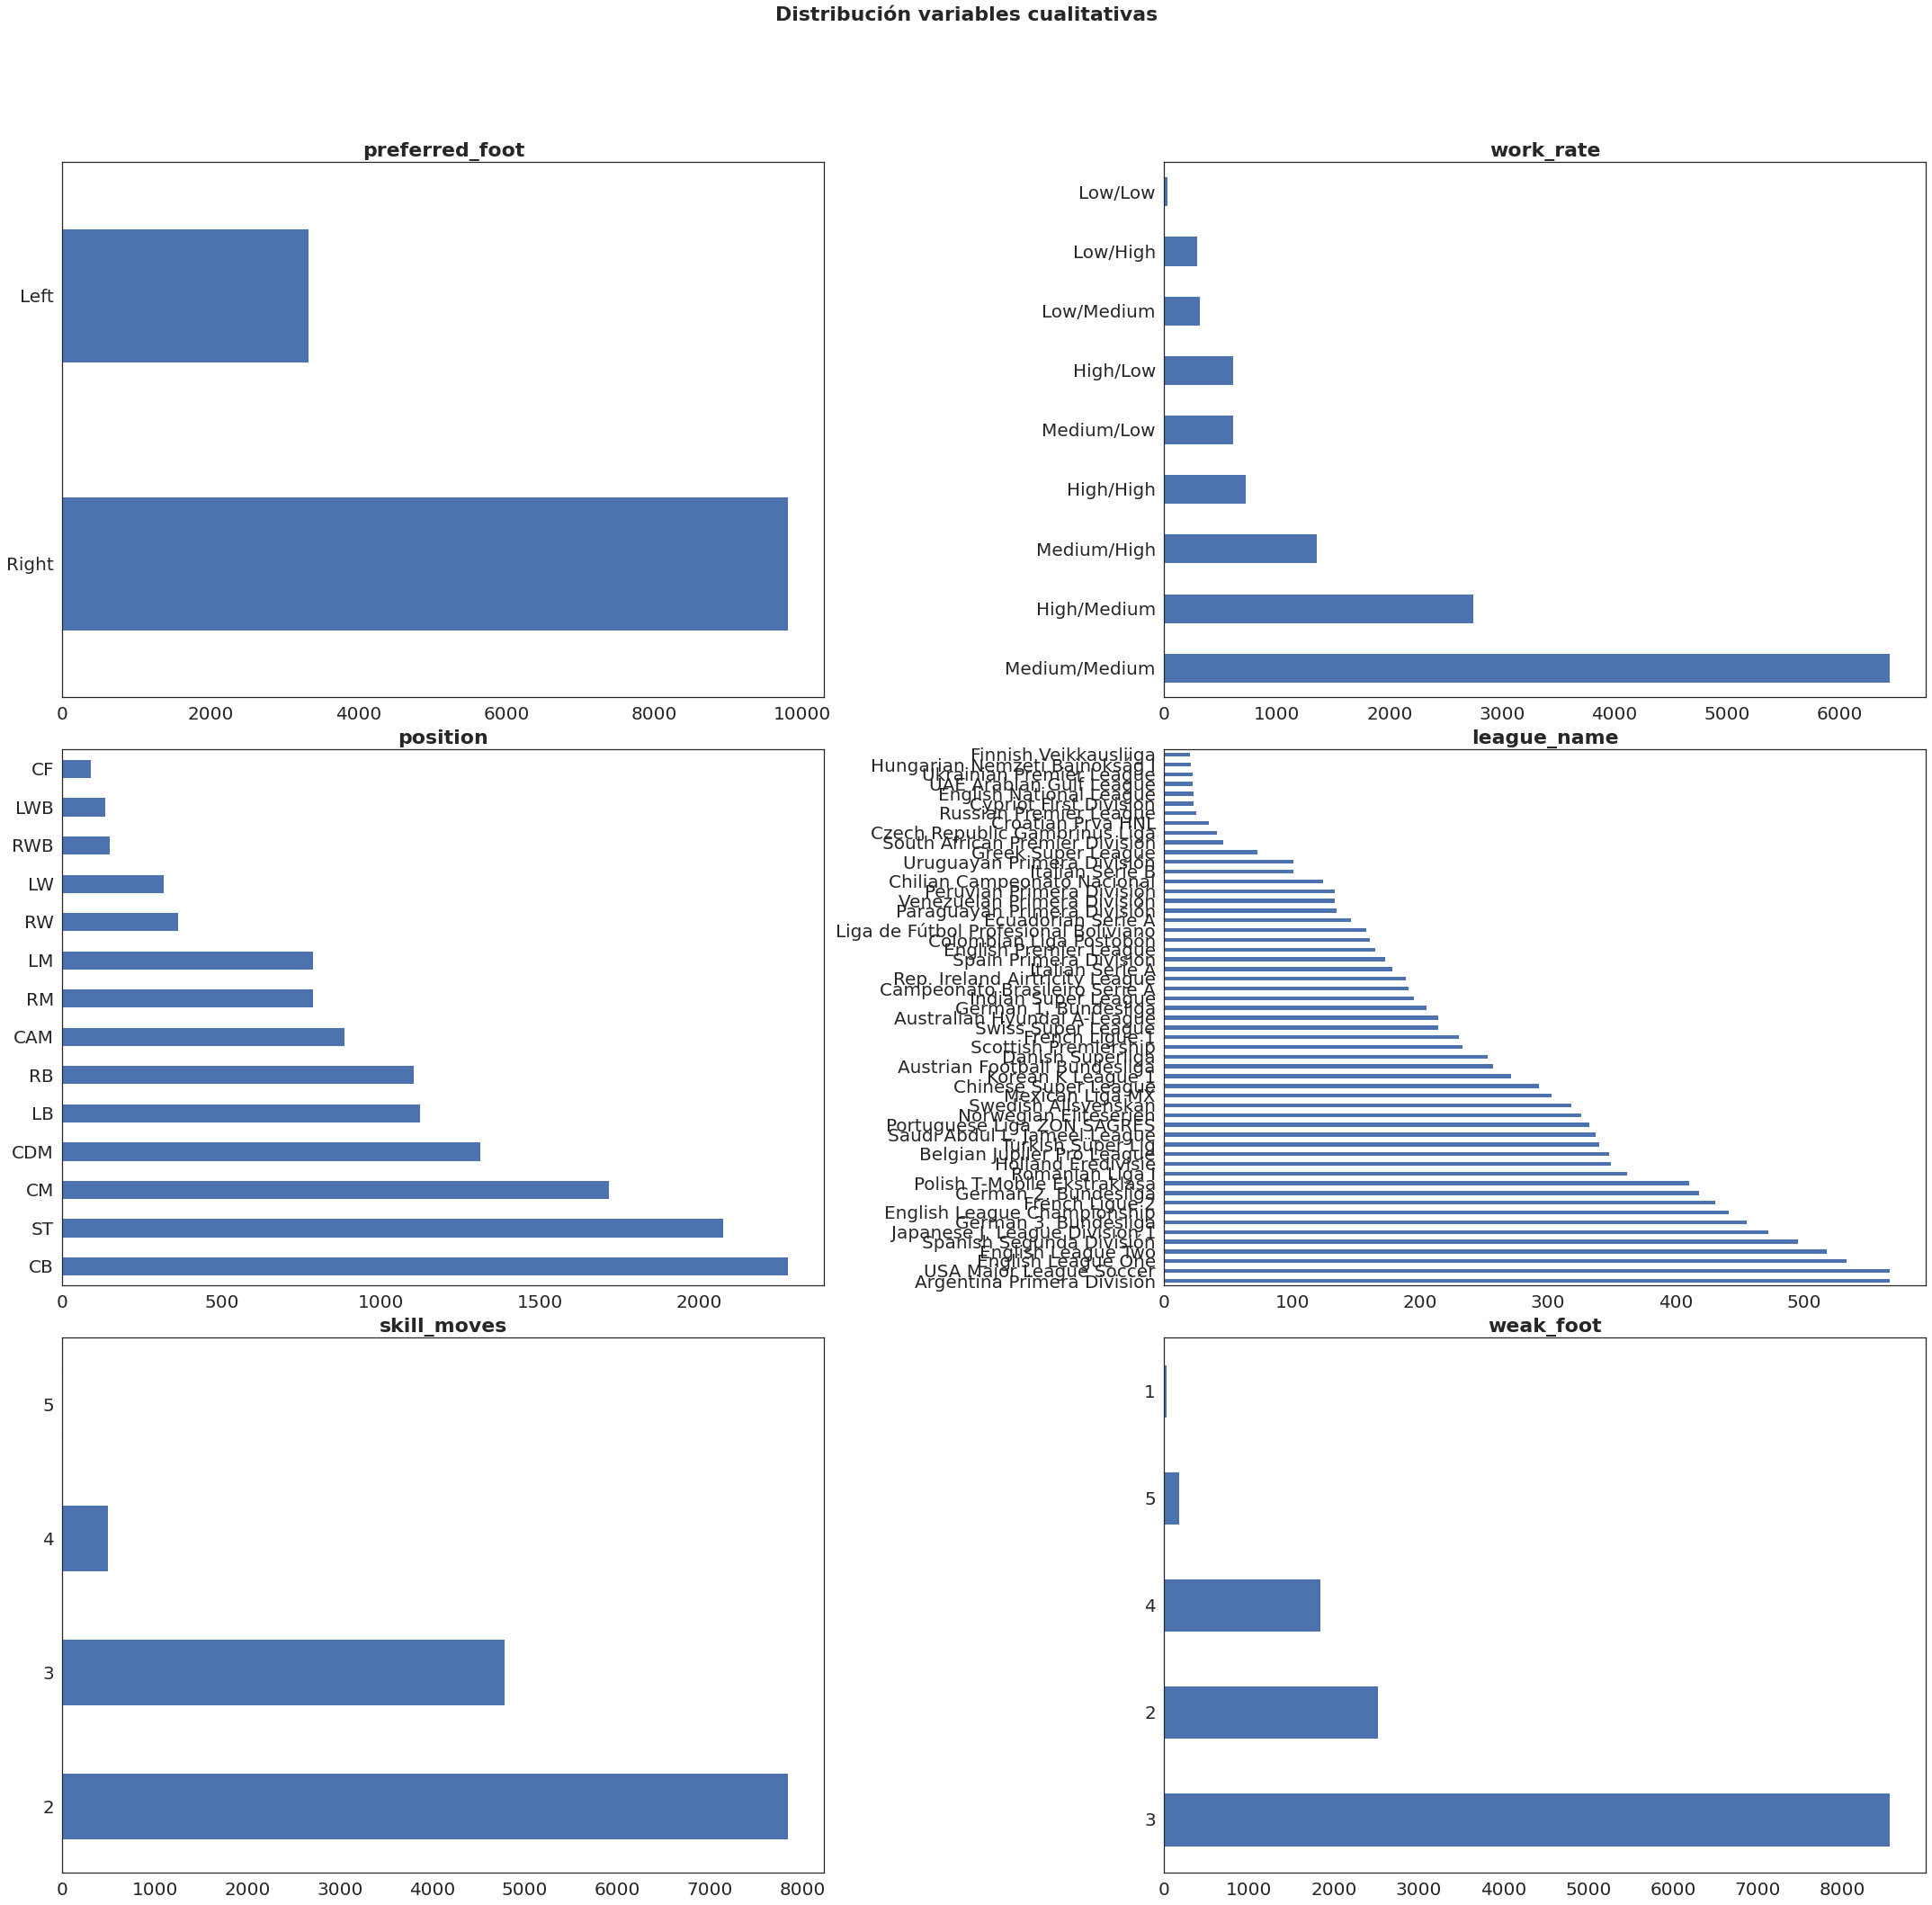

In [212]:
# Gráfico para cada variable cualitativa
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 30))
axes = axes.flat
columnas_object = players[["preferred_foot","work_rate","position","league_name","skill_moves","weak_foot"]]
for i, colum in enumerate(columnas_object):
    players[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 22, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

  
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 22, fontweight = "bold");

### Distribución Variables Categóricas vs. Precio

En este otro aprtado, podemos observar la distribución de las variables categóricas en función del precio de los jugadores. Algunas de las conclusiones a las que hemos llegado son:

*   **Preferred_foot**: la mediana del precio de los jugadores zurdos es mayor que la de los diestros ya que hay menos jugadores zurdos y se **cotizan** más a la hora de buscar un buen jugador zurdo en el mercado por los pocos que hay.
*  **Work_rate**: los jugadores más valorados económicamente en el mercado son los que tienen un nivel de esfuerzo mayor.
*   **Position**: La mediana de los precio de los jugadores que ocupan las posiciones de **LW** o Lateral Izquierdo y **CF** o Media punta son las más altas al ser jugadores difíciles de encontrar en el mercado que aseguren un buen rendimiento.
*   **League_name**: La liga con mayor mediana del precio de los jugadores es la *Liga de la República Checa*. Esto puede ser un poco contradictorio porque los jugadores más valiosos suelen estar en las principales ligas europeas como la española, inglesa, italiana, francesa o alemana. Esto, sin embargo, puede deberse a que hemos quitado los outliers anteriormente y la mayor parte de ellos se concentran en estas ligas al presentar los jugadores más valiosos como De Bruyne, Lewandowski, Messi, Neymar, Benzema, etc.
*   **Skill_moves**: la mediana del precio de los jugadores con un nivel de **habilidades técnicas**  de **5 sobre 5** es el dato más elevado respecto al resto de niveles como cabe de esperar. Es lógico al tratarse los mejores jugadores técnicos.
*   **Weak_foot**: los jugadores que poseen una habilidad sobre su pierna **NO dominante** de **5 sobre 5** son los jugadores con mayor precio en el mercado como cabe de esperar al poder jugar indistintamente con ambas piernas.










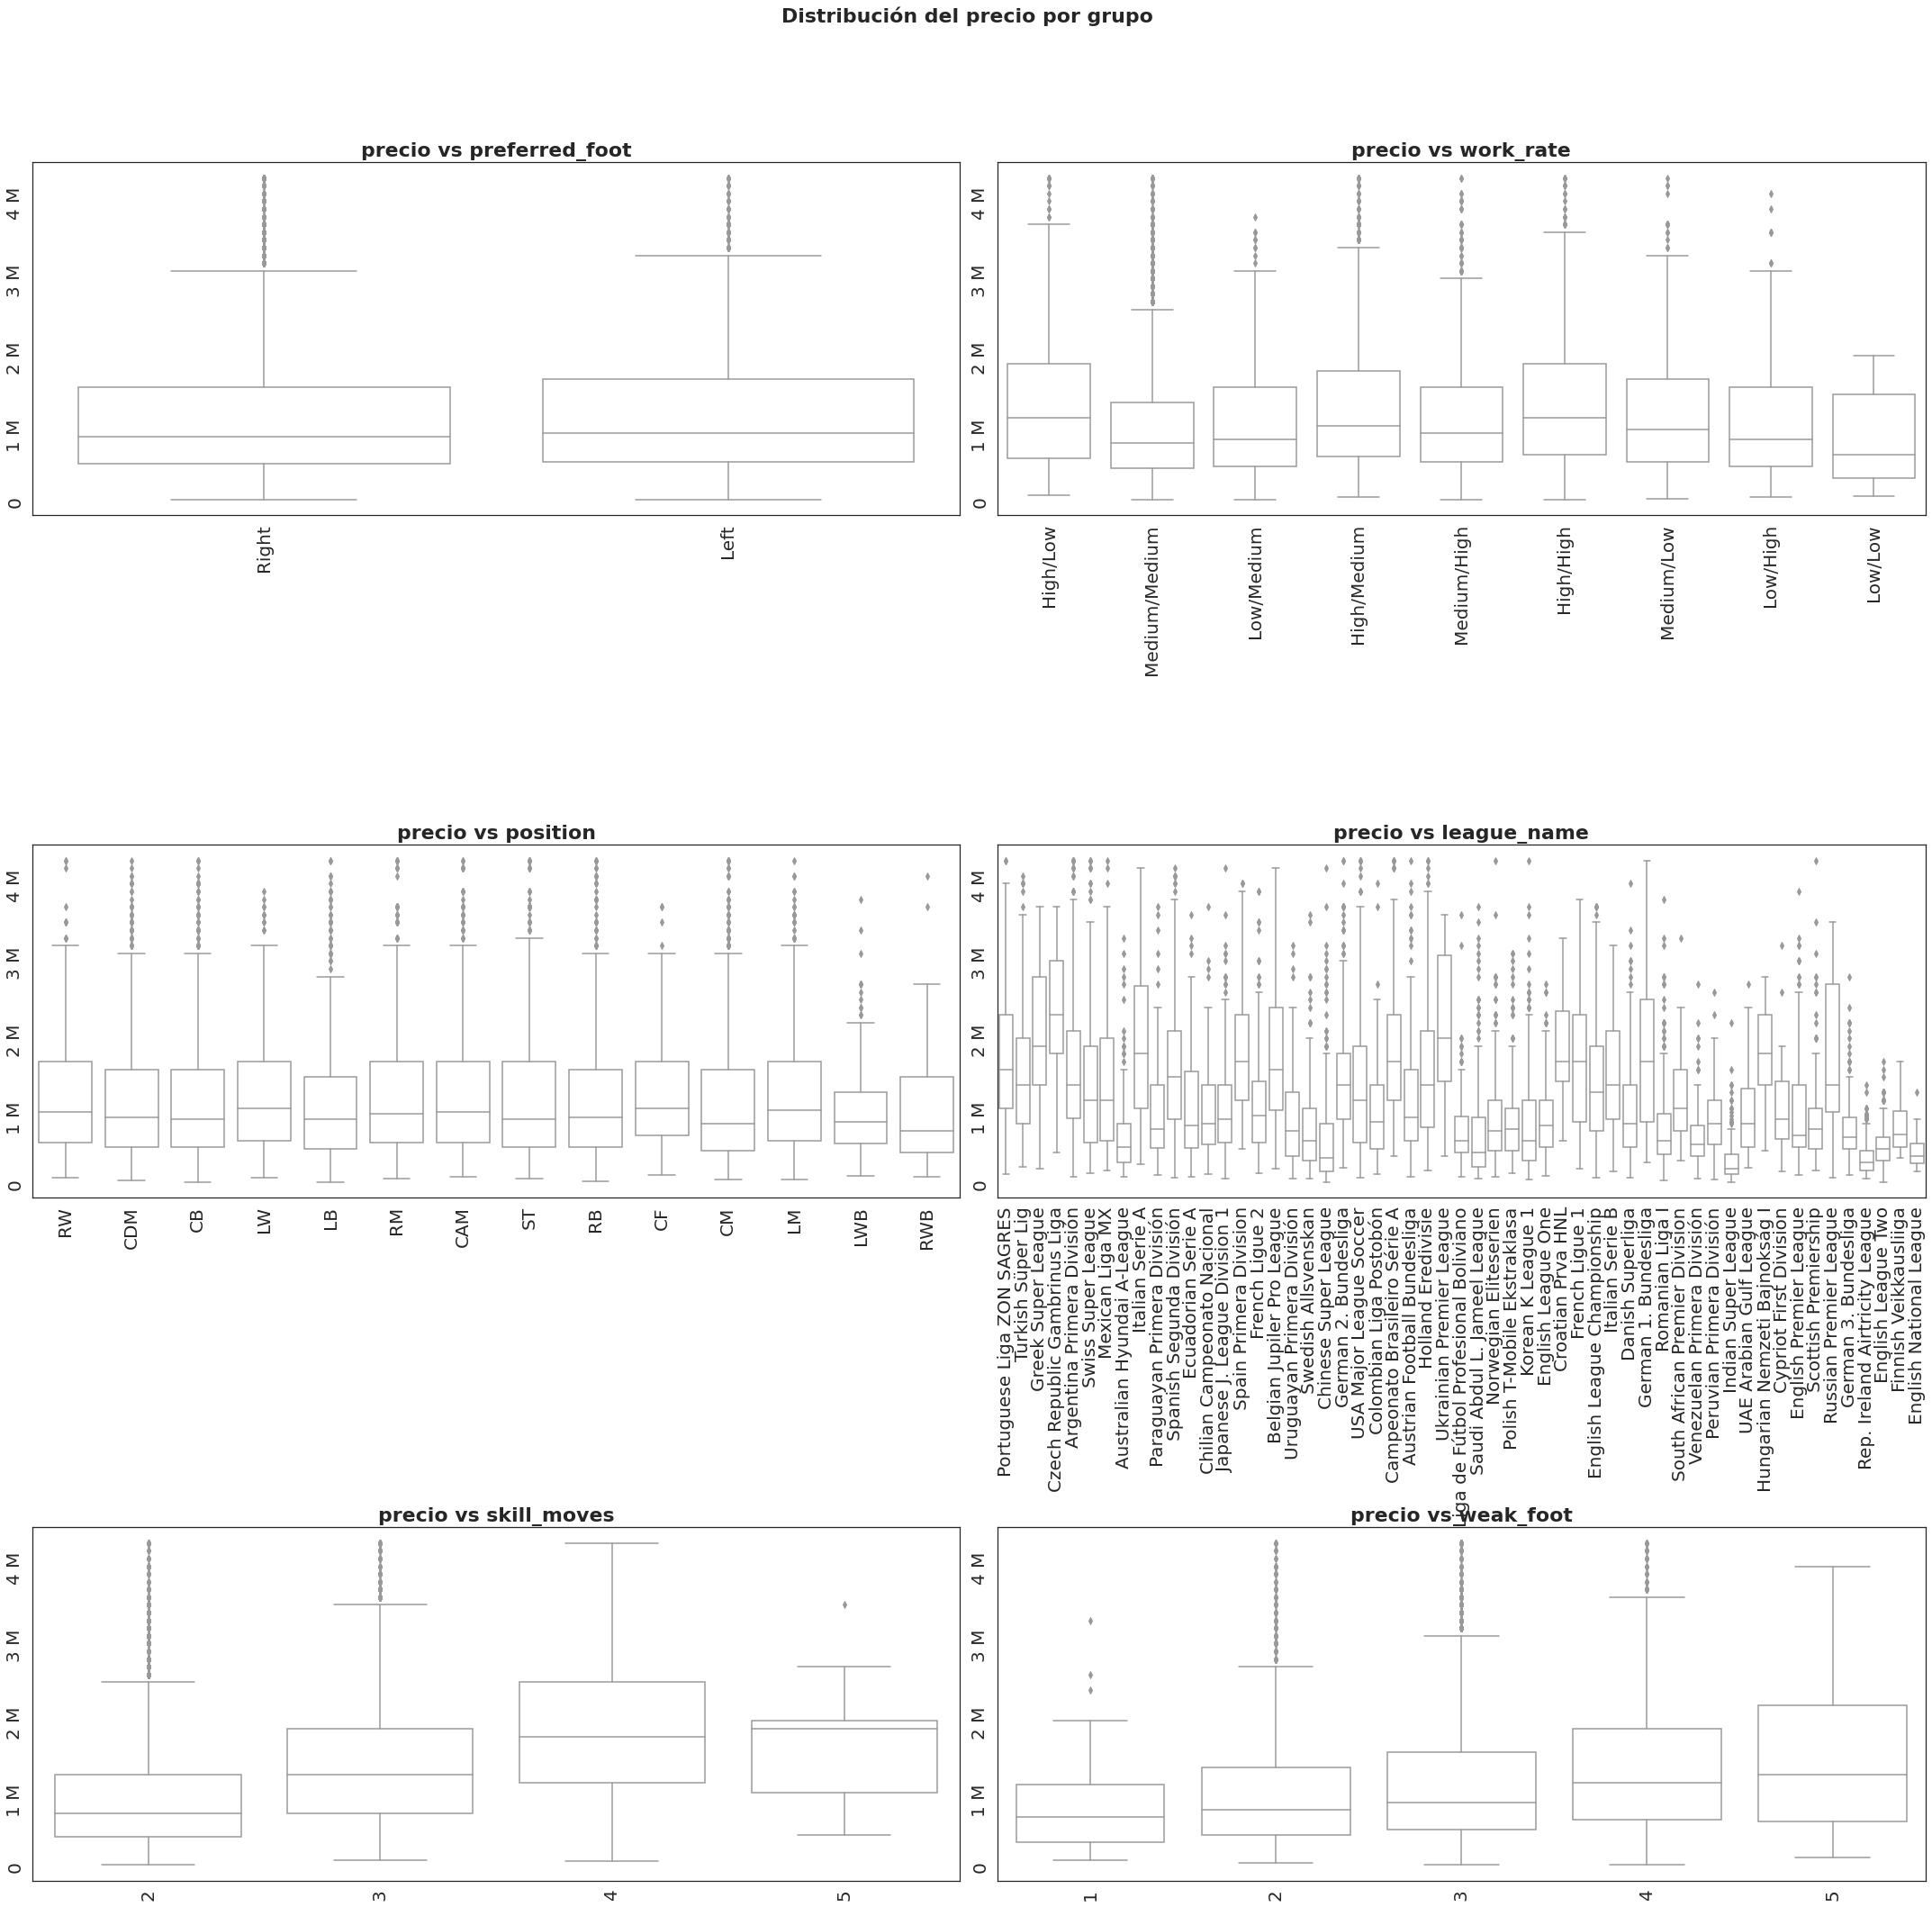

In [274]:
# Gráfico relación entre el precio y cada cada variables cualitativas
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 30),)
axes = axes.flat
columnas_object = players[["preferred_foot","work_rate","position","league_name","skill_moves","weak_foot"]]

for i, colum in enumerate(columnas_object):
    sns.boxplot(
        x     = colum,
        y     = 'value_eur',
        data  = players,
        color = "blue",
        ax    = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 22, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 20, rotation = 90)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del precio por grupo', fontsize = 22, fontweight = "bold");

# Separación entre Train y Test

In [214]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        players.drop('value_eur', axis = 'columns'),
                                        players['value_eur'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True,
                                        )

## Particiones y Balanceo

In [215]:
# Partición datos de entrenamiento
# ==============================================================================
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count    1.050000e+04
mean     1.108079e+06
std      8.148624e+05
min      4.500000e+04
25%      5.000000e+05
50%      8.750000e+05
75%      1.500000e+06
max      4.200000e+06
Name: value_eur, dtype: float64


In [216]:
# Partición datos de test
# ==============================================================================
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count    2.626000e+03
mean     1.109061e+06
std      8.365775e+05
min      7.000000e+04
25%      4.750000e+05
50%      8.500000e+05
75%      1.500000e+06
max      4.200000e+06
Name: value_eur, dtype: float64


Como podemos observar tras la separación entre **train y test**, los estadísticos principales son idénticos o similares en ambos casos evidenciando un buen balanceo entre los mismos. 

## Preprocesado de valores missing

Una vez comprobado el balanceo de los datos, es momento de tratar aquellos valores nulos que no hemos modificado antes.
Para ello, y puesto que los NAs restantes son complementarios, decidimos rellenarlos con 0s. 
Esto es así dado que todos los NAs dentro de **goalkeeping_speed** se corresponden a jugadores de campo, que tienen 0 en esta estadística, y lo mismo ocurre con las variables de jugadores de campo para los porteros

### Datos Train

In [217]:
import statistics as st

X_train["goalkeeping_speed"] = X_train["goalkeeping_speed"].fillna(0)
X_train["pace"] = X_train["pace"].fillna(0)
X_train["shooting"] = X_train["shooting"].fillna(0)
X_train["passing"] = X_train["passing"].fillna(0)
X_train["dribbling"] = X_train["dribbling"].fillna(0)
X_train["defending"] = X_train["defending"].fillna(0)
X_train["physic"] = X_train["physic"].fillna(0)

### Datos Test

In [218]:
X_test["goalkeeping_speed"] = X_test["goalkeeping_speed"].fillna(0)
X_test["pace"] = X_test["pace"].fillna(0)
X_test["shooting"] = X_test["shooting"].fillna(0)
X_test["passing"] = X_test["passing"].fillna(0)
X_test["dribbling"] = X_test["dribbling"].fillna(0)
X_test["defending"] = X_test["defending"].fillna(0)
X_test["physic"] = X_test["physic"].fillna(0)

### Comprobación

In [219]:
# Número de datos ausentes por variable
# ==============================================================================
missing_values_table(X_train)

Your selected dataframe has 58 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# Modelo de entrenamiento Regresión Lineal

In [220]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

In [221]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [222]:
X_train_prep = pd.DataFrame(preprocessor.fit_transform(X_test).toarray())


encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [224]:
labels = labels.tolist()

In [225]:
X_train_prep.columns = labels


In [226]:
X_train_prep

,overall,potential,wage_eur,age,height_cm,weight_kg,club_contract_valid_until,pace,shooting,passing,...,position_CM,position_LB,position_LM,position_LW,position_LWB,position_RB,position_RM,position_RW,position_RWB,position_ST
0,-0.994602,0.203838,-0.860915,-1.256555,-0.818103,-1.234297,-1.434290,-0.346708,0.455430,-0.461075,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.330964,-0.185881,-0.729028,-1.473914,-1.962227,-0.585460,0.269599,-0.243971,-1.572943,-1.878579,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.105396,0.008979,0.326066,1.569101,-0.491210,-0.261042,-0.582346,-0.963129,1.001531,1.901430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.296305,0.398698,1.908706,0.482310,-0.818103,0.225586,0.269599,1.194345,1.625646,1.547054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.341760,0.398698,-0.201481,-0.169765,0.162575,0.225586,-0.582346,2.221714,0.455430,0.129551,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,-1.567329,0.593557,-0.465255,-1.256555,-0.818103,-1.234297,-0.582346,0.064240,-0.558756,0.011426,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2622,1.296305,0.203838,-0.768594,0.917026,-1.635335,-0.098833,-0.582346,0.680661,1.391603,1.547054,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2623,0.341760,-0.575600,-0.729028,0.482310,0.326021,0.387795,1.121543,0.372450,0.845502,0.956428,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2624,-0.230966,-1.355038,-0.201481,1.134385,-0.327764,0.550004,-0.582346,1.297082,0.533445,0.011426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [227]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge


# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
4,13.560151,-323979.958984,7864.756193,-304211.670631,1919.342623


## Validación

In [228]:
# Validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-322473.70893658 -309109.06140349 -329499.92362946 -337777.25306529
 -335452.46858954]
Média métricas de validación cruzada: -326862.4831248736


## Validación cruzada repetida

In [229]:
# Validación cruzada repetida
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
             )

print(f"Métricas de validación cruzada: {cv_scores}")
print("")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas de validación cruzada: [-326209.6518692  -312848.06026682 -332393.34843119 -327409.65076039
 -336689.99057291 -317300.15095232 -349632.50936869 -334607.52329144
 -319735.54618604 -314071.46855145 -325033.31742692 -331285.05637756
 -337204.77283116 -319147.54232235 -323206.89082705 -336909.05167372
 -316273.99554735 -331700.78932574 -330703.4363993  -324953.5287905
 -345502.22658895 -322689.98602696 -326244.99609156 -329648.25772222
 -310591.50777423]

Média métricas de validación cruzada: -327279.73023904


In [230]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores



,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.176874,0.036400,0.835624,0.873317,-327560.638261,-291219.520199
1,0.162841,0.039570,0.836255,0.873609,-329520.050500,-289769.681106
2,0.166277,0.032547,0.831653,0.874380,-337289.906416,-287498.518592
3,0.166635,0.032310,0.830773,0.875261,-337191.712732,-286893.005542
4,0.168432,0.033114,0.830548,0.875955,-340855.231600,-284598.103182
5,0.161543,0.032913,0.838577,0.870678,-319898.258864,-296311.087429
6,0.164245,0.033667,0.840259,0.872218,-326836.363668,-290737.343591
7,0.177185,0.037388,0.829478,0.876423,-339457.704202,-285138.284537
8,0.171374,0.032452,0.839962,0.872143,-321722.182897,-293174.096659
9,0.169420,0.033299,0.833213,0.874968,-334444.077741,-287392.820777


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


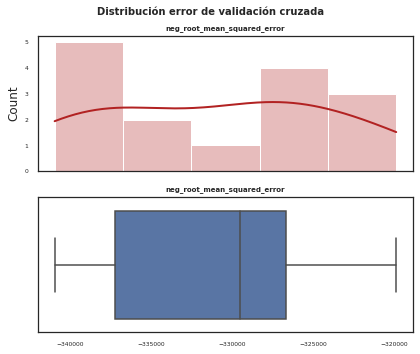

In [231]:
# Distribución del error de validación cruzada
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.histplot(
    data    = cv_scores['test_neg_root_mean_squared_error'],
    stat    = "count",
    kde     = True,
    line_kws= {'linewidth': 2},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
)

axes[0].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[0].tick_params(labelsize = 6)
axes[0].set_xlabel("")
    
sns.boxplot(
    cv_scores['test_neg_root_mean_squared_error'],
    ax      = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[1].tick_params(labelsize = 6)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución error de validación cruzada', fontsize = 10,
             fontweight = "bold");



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


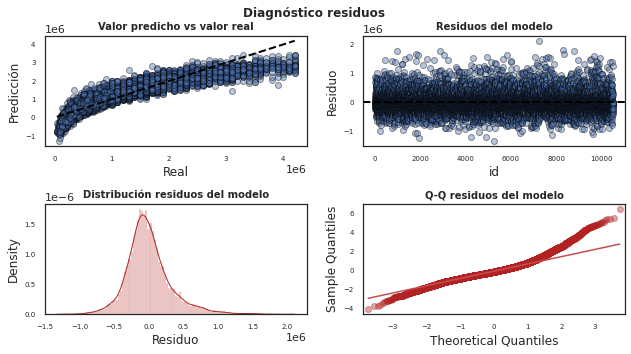

In [232]:
# Diagnóstico errores (residuos) de las predicciones de validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import statsmodels.api as sm

# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_prediccones = cross_val_predict(
                    estimator = pipe,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                  )

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))

axes[0, 0].scatter(y_train, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), y_train - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

Al haber eliminado tanta informacion en los outliers (principalmente de las grandes ligas) las predicciones que realiza el modelo se basan en jugadores de precios relativamente bajos, haciendo que en caso de existir un jugador de mayor precio, estime hacia abajo, explicando el error medio negativo dentro de este modelo. (**325.921 euros**)

In [233]:
# Validación cruzada repetida paralelizada (multicore)
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv,
                n_jobs    = -1 # todos los cores disponibles
             )

print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Média métricas de validación cruzada: -325921.8668855154


## Predicciones

In [234]:
predicciones = grid.predict(X_test)

In [236]:


# Se crea un dataframe con las predicciones y el valor real
df_predicciones = pd.DataFrame({'precio' : y_test, 'prediccion' : predicciones})
df_predicciones.head(15)



,precio,prediccion
long_name,,
Wilmer Rojas,525000.0,7.899282e+05
Mohammed Al Oufi,190000.0,-2.078265e+05
신진호 申振豪,1100000.0,1.419783e+06
Abdallah Kerim Mrabti,2200000.0,2.188856e+06
Chiedozie Ogbene,1400000.0,1.260889e+06
Joe Riley,725000.0,9.701832e+05
Christian Frederick Bayoi Makoun Reyes,1100000.0,1.324459e+06
Moisés Isaac Caicedo Corozo,1400000.0,1.842375e+06
Martín Manuel Calderón Gómez,1900000.0,1.709831e+06


## Error del modelo

In [237]:
# neg_root_mean_squared_error de test
# ==============================================================================
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 332904.2296940747


## Coeficientes del modelo

Tras realizar la regresión, podemos llegar al siguiente modelo: ***value_eur = 514.500 + 659000overall + 101.900potential + 222.500 wage_eur -398.700age ...***

In [239]:

# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train_lm = sm.add_constant(X_train_prep, prepend=True)
modelo_lm = sm.OLS(endog=list(y_test), exog=X_train_lm,)
modelo_lm = modelo_lm.fit()
print(modelo_lm.summary())



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     18.26
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:07:34   Log-Likelihood:                -36456.
No. Observations:                2626   AIC:                         7.470e+04
Df Residuals:                    1730   BIC:                         7.997e+04
Df Model:                         895                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

# KNN

## Modelo

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
numeric_cols = X_train.select_dtypes(include=['float', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__n_neighbors': np.linspace(1, 100, 500, dtype=int)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_neighbors,mean_test_score,std_test_score,mean_train_score,std_train_score
12,7,-380906.408862,9044.175677,-329084.60044,2390.841069


Tras crear el modelo KNN, el número óptimo de parámetros a estimar es de 12 y el número de vecinos de 7.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

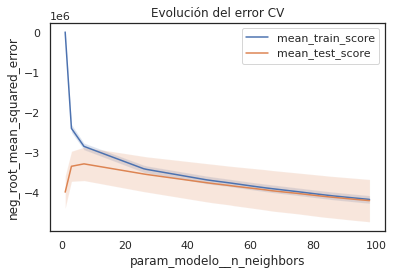

In [ ]:


# Gráfico resultados validación cruzada para cada hiperparámetro
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 3.84))
hiperparametro = 'param_modelo__n_neighbors'
resultados = resultados.sort_values(hiperparametro, ascending = False)
metrica    = grid.scoring

resultados.plot(hiperparametro, 'mean_train_score', ax=ax)
resultados.plot(hiperparametro, 'mean_test_score', ax=ax)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel(metrica);



Este gráfico muestra la evolución del error en función del número de parámetros escogidos por el modelo. A mayor número de parámetros el error se reduce progresivamente, llegando a un punto en el que no es eficiente aumentar el número de parámetros por la poca reducción del error que conlleva esto.

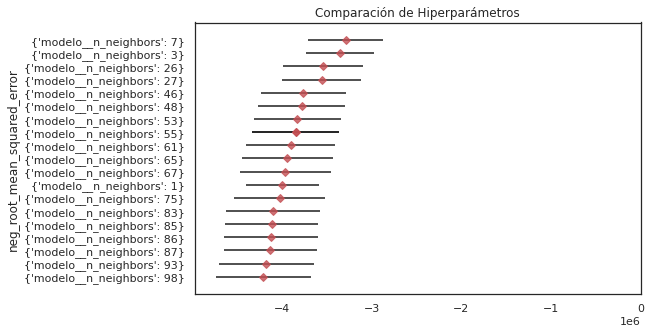

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

resultados = resultados.sort_values('mean_test_score', ascending = True)

ax.barh(
    [str(d) for d in resultados['params']],
    resultados['mean_test_score'],
    xerr=resultados['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    resultados['mean_test_score'],
    [str(d) for d in resultados['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Comparación de Hiperparámetros')
ax.set_ylabel(metrica);

Nuestro modelo escoge un total de 7 vecinos al ser el que menos **error cuadrático medio** presenta.

## Error del modelo

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")



El error (rmse) de test es: 390566.56502322014


# Gradient Boosting

### Modelo

In [273]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

import warnings
warnings.filterwarnings('once')
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__subsample,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
15,1,100,auto,3,-87435.492061,3428.123243,-78743.778589,1599.126072


Encontramos que el modelo más eficaz es aquel con 15 parámetros, 1 subsample, 100 estimadores y 3 niveles de profundidad.

## Error del modelo

Falta explicación del error y puesto que al ejecutarlo una última vez encontramos un error que no tenemos en el resto de modelos y que no somos capaces de solucionar pese a tener el mismo código.

In [277]:


# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_gbm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_gbm}")



KeyError: ignored

# Random Forest

In [278]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
0,50,auto,20,-61749.973852,3784.724936,-24200.291197,519.636775


### Error del modelo

In [283]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")


KeyError: ignored

In [ ]:
modelo = RandomForestRegressor(
            n_estimators = 50,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

In [ ]:
modelo.fit(preprocessor.fit_transform(X_train),y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', n_estimators=50, n_jobs=-1,
                      random_state=123)

## Importancia de cada variable

Para el modelo de random forest, hemos obtenido las variables que mayor información proporcionan a éste y son las siguientes:

*   **overall**
*   **potential**
*   **age**
*   **wage_eur**

Una vez mencionadas estas cuatro, según este modelo, las variables que más aportan son las relacionadas con el ataque del jugador, pudiendo afirmar que un atacante a igualdad de media, potencial, etc., tendrá un precio superior a cualquier otra posición del juego.






In [ ]:


importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)



,importances_mean,importances_std,feature
0,7.734005e+06,45012.262661,overall
1,4.136971e+06,28175.512299,potential
3,1.125926e+06,29461.423280,age
2,2.060194e+05,2730.443575,wage_eur
34,6.653454e+04,966.456725,movement_sprint_speed
36,4.441443e+04,219.206013,movement_reactions
20,3.720815e+04,778.515941,dribbling
17,3.172055e+04,1735.566556,pace
40,2.961396e+04,3242.194639,power_stamina
15,2.743429e+04,396.326264,international_reputation


## Representación del árbol

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(preprocessor.fit_transform(X_train), y_train)# Extract the small tree
tree_small = rf_small.estimators_[5]# Save the tree as a png image

In [ ]:
from sklearn.tree import export_graphviz

In [ ]:
export_graphviz(tree_small, out_file='tree.dot', 
                rounded = True, proportion = False, 
                feature_names= preprocessor.fit_transform(X_train).columns,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

AttributeError: ignored